In [1]:
import numpy as np
import pandas as pd
import h5py
from affinewarp import PiecewiseWarping
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d

In [57]:
Spk =  h5py.File("F:/ComSub/code/ComSub-master/mytry/Spk.mat","r")
df = pd.read_csv("F:/ComSub/code/ComSub-master/mytry/behsample.csv")

time_of_spikecounts = np.array(Spk['Spk']['timeBinMidPoints']).ravel()
spikeCountMatrix = np.array(Spk['Spk']['spikeCountMatrix'])
print(time_of_spikecounts.shape)
print(spikeCountMatrix.shape)

(607606,)
(607606, 224)


In [58]:
## creating templates

df = df[df['rewarded'] == 1]

# Assign 'trajectory_type' from 'trajclass'
df['trajectory_type'] = df['trajclass']

# Create 100 bins for 'percent_time_progress'
df['lindist_binned'] = pd.cut(df['lindist'], bins=40, labels=False)

# For each trajectory type and each bin, calculate the median X and Y values
templates = df.groupby(['trajectory_type', 'lindist_binned'])[['X', 'Y']].median().reset_index()

print(templates[templates['trajectory_type']==2])


    trajectory_type  lindist_binned          X           Y
40                2               0  78.249352  100.887272
41                2               1  81.981910   91.579469
42                2               2  80.585689   87.064669
43                2               3  77.403095   81.185193
44                2               4  77.623995   76.659962
45                2               5  77.760654   71.442970
46                2               6  77.868074   65.954084
47                2               7  77.826871   60.962493
48                2               8  78.334283   55.858366
49                2               9  78.461528   50.856124
50                2              10  78.394080   46.036510
51                2              11  79.000573   41.743950
52                2              12  80.526614   35.945959
53                2              13  81.809492   30.786494
54                2              14  81.254667   26.643798
55                2              15  80.949018   18.1800

In [ ]:
## create templates_smoothed

from scipy.signal import savgol_filter

templates_smoothed = pd.DataFrame()

# Apply Savitzky-Golay smoothing to each trajectory type
for traj_type in templates['trajectory_type'].unique():
    traj_data = templates[templates['trajectory_type'] == traj_type].copy()
    traj_data['X'] = savgol_filter(traj_data['X'], 5, 2) # window size 5, polynomial order 2
    traj_data['Y'] = savgol_filter(traj_data['Y'], 5, 2) # window size 5, polynomial order 2
    templates_smoothed = templates_smoothed.append(traj_data)

templates_smoothed["trajectory_type"].unique()

array([1, 2, 3, 4], dtype=int64)

In [ ]:
grouped = df.groupby(['trajectory_type', 'trajall'])

for name, group in grouped:
    if name[0] == 2: 
        print(f"Group {name}: size {group.size}")



Group (2, 1): size 16170
Group (2, 2): size 21525
Group (2, 8): size 10857
Group (2, 9): size 588
Group (2, 13): size 5880
Group (2, 18): size 9429
Group (2, 23): size 10143
Group (2, 24): size 714
Group (2, 27): size 9387
Group (2, 29): size 23331
Group (2, 30): size 126
Group (2, 31): size 42
Group (2, 36): size 1281
Group (2, 41): size 4557
Group (2, 42): size 42189
Group (2, 44): size 126
Group (2, 47): size 903
Group (2, 48): size 12579
Group (2, 54): size 7581
Group (2, 57): size 168
Group (2, 58): size 6846
Group (2, 66): size 5880
Group (2, 68): size 5607
Group (2, 73): size 168
Group (2, 74): size 7098
Group (2, 77): size 105
Group (2, 78): size 4788
Group (2, 81): size 84
Group (2, 82): size 5061
Group (2, 89): size 22218
Group (2, 90): size 966
Group (2, 92): size 14574
Group (2, 93): size 17955
Group (2, 94): size 651
Group (2, 96): size 105
Group (2, 97): size 8421
Group (2, 99): size 6279
Group (2, 101): size 13818
Group (2, 106): size 42
Group (2, 107): size 6090
Group (

In [ ]:
from tqdm import tqdm
def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin):
#def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin, move_threshold):
    # Initialize a dictionary to hold the aligned spike counts for each trajectory type
    aligned_counts = {i: [None]*100 for i in range(1, 5)}
    X_collected = {i: [] for i in range(1, 5)}
    Y_collected = {i: [] for i in range(1, 5)}
    L_collected = {i: [] for i in range(1, 5)}

    # Create an interpolation function for the spike count matrix
    f = interp1d(time_of_spikecounts, spikeCountMatrix, axis=0, bounds_error=False, fill_value="nan")

    # Group the DataFrame by trajectory type and trial ID
    for (traj_type, trajall), group in tqdm(df.groupby(['trajectory_type', 'trajall']), desc="Processing items", ncols=100):
        # Select the template for this trajectory type
        template = templates[templates['trajectory_type'] == traj_type][['X', 'Y']].values

        trial = group[['X', 'Y']].values

        # Calculate the DTW path between the trial and the template
        _, path = fastdtw(trial, template, dist=euclidean)

        '''
        # Calculate the total change in the X and Y coordinates along the path
        total_change = np.sum(np.abs(np.diff(trial[[p[0] for p in path]], axis=0)))

        # If the total change is below the threshold, discard this path
        if total_change < move_threshold:
            continue
        '''

        X_trial = []
        Y_trial = []
        L_trial = []

        # Create a mapping from template bins to trial indices
        bin_to_indices = {i: [] for i in range(100)}
        for trial_idx, template_idx in path:
            bin_to_indices[template_idx].append(trial_idx)

        try:
            # For each template bin, gather the corresponding spike count matrices
            for bin_idx, trial_indices in bin_to_indices.items():

                # Interpolate 
                trial_indices = np.interp(
                    np.linspace(0, len(trial_indices) - 1, n_points_per_bin),
                    np.arange(len(trial_indices)),
                    trial_indices
                )

                behavior_times = group.iloc[trial_indices]['time'].values

                spike_counts_bin = f(behavior_times)
 
                if aligned_counts[traj_type][bin_idx] is None:
                    aligned_counts[traj_type][bin_idx] = spike_counts_bin
                else:
                    aligned_counts[traj_type][bin_idx] = np.concatenate([aligned_counts[traj_type][bin_idx], spike_counts_bin], axis=0)

                X_trial.append(group.iloc[trial_indices]['X'].values)
                Y_trial.append(group.iloc[trial_indices]['Y'].values)
                L_trial.append([bin_idx] * len(trial_indices))
        except:
            print((traj_type, trajall))
            print(trial.shape)
            continue

        X_collected[traj_type].append(X_trial)
        Y_collected[traj_type].append(Y_trial)
        L_collected[traj_type].append(L_trial)

    return aligned_counts, X_collected, Y_collected, L_collected

In [ ]:
from tqdm import tqdm

def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts):
#def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin, move_threshold):
    # Initialize a dictionary to hold the aligned spike counts for each trajectory type
    aligned_counts = {i: [None]*100 for i in range(1, 5)}

    f = interp1d(time_of_spikecounts, spikeCountMatrix, axis=0, bounds_error=False, fill_value="nan")

    # Group the DataFrame by trajectory type and trial ID
    for (traj_type, trajall), group in tqdm(df.groupby(['trajectory_type', 'trajall']), desc="Processing items", ncols=100):

        template = templates[templates['trajectory_type'] == traj_type][['X', 'Y']].values

        trial = group[['X', 'Y']].values

        _, path = fastdtw(trial, template, dist=euclidean)

        bin_to_indices = {i: [] for i in range(100)}
        for trial_idx, template_idx in path:
            bin_to_indices[template_idx].append(trial_idx)


        for bin_idx, trial_indices in bin_to_indices.items():

            behavior_times = group.iloc[trial_indices]['time'].values

            spike_counts_bin = f(behavior_times)
            spike_counts_bin = np.mean(spike_counts_bin, axis=0)
 
            if aligned_counts[traj_type][bin_idx] is None:
                aligned_counts[traj_type][bin_idx] = spike_counts_bin
            else:
                aligned_counts[traj_type][bin_idx] = np.vstack((aligned_counts[traj_type][bin_idx], spike_counts_bin))

    return aligned_counts

In [63]:
#check fun_version 2
aligned_counts = align_trials(df, templates, spikeCountMatrix, time_of_spikecounts)

Processing items:   0%|                                                     | 0/439 [00:00<?, ?it/s]c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
Processing items: 100%|███████████████████████████████████████████| 439/439 [00:41<00:00, 10.70it/s]


In [57]:
X_collected2 = {i: [] for i in range(1, 5)}
Y_collected2 = {i: [] for i in range(1, 5)}
L_collected2 = {i: [] for i in range(1, 5)}

for i in range(1,5):
    X_collected2[i] = [np.hstack(X_collected[i][j]) for j in range(len(X_collected[i]))]
    Y_collected2[i] = [np.hstack(Y_collected[i][j]) for j in range(len(Y_collected[i]))]
    L_collected2[i] = [np.hstack(L_collected[i][j]) for j in range(len(L_collected[i]))]

In [64]:
aligned_counts_now = {}
aligned_counts_now["in_left"] = []
aligned_counts_now["in_right"] = []
aligned_counts_now["out_left"] = []
aligned_counts_now["out_right"] = []

for key in aligned_counts.keys():
    
    aligned_counts_now[list(aligned_counts_now.keys())[key-1]] = np.array([matrix for matrix in aligned_counts[key] if not np.all(np.isnan(matrix))])

print(aligned_counts_now["in_left"].shape)

(40, 114, 224)


In [53]:
aligned_counts_now["in_left"][3]

array([[ 0.79644364,  0.67483697,  0.17926988, ...,  0.29884337,
         0.67207099, -0.08707271],
       [ 0.36393758,  1.34729449, -0.02421877, ..., -0.25465065,
        -0.23803314, -0.86042272],
       [-0.18592145,  1.93863448, -0.64625544, ...,  1.03903327,
        -0.23803314,  1.4073703 ],
       ...,
       [-0.51945077, -0.72840103,  1.04430443, ..., -0.76723001,
        -0.23803314, -0.87989513],
       [-0.51945077, -0.72840103, -0.64625544, ..., -0.32344101,
        -0.23803314, -0.35703977],
       [-0.49215133, -0.03412651,  0.49890778, ..., -0.81502255,
        -0.23803314, -0.67777275]])

In [55]:
from scipy.io import savemat
savemat('F:/ComSub/code/ComSub-master/mytry/aligned_spikeCountTensor.mat', aligned_counts_now)


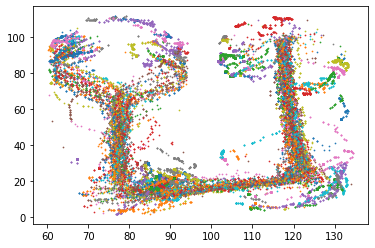

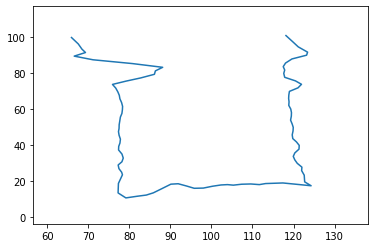

In [ ]:
import matplotlib.pyplot as plt

X1 = X_collected2[3]
Y1 = Y_collected2[3]

assert len(X1) == len(Y1)

fig1 = plt.figure()

for i in range(len(X1)):

    x_path = X1[i]
    y_path = Y1[i]

    assert len(x_path) == len(y_path)

    plt.scatter(x_path, y_path, s=0.5)

xlim1 = plt.xlim()
ylim1 = plt.ylim()

plt.show()

plt.figure()
template = templates_smoothed[templates_smoothed['trajectory_type'] == 3][['X', 'Y']].values
x_template = template[:, 0]
y_template = template[:, 1]

assert len(x_template) == len(y_template)

plt.plot(x_template, y_template)

plt.xlim(xlim1)
plt.ylim(ylim1)

plt.show()

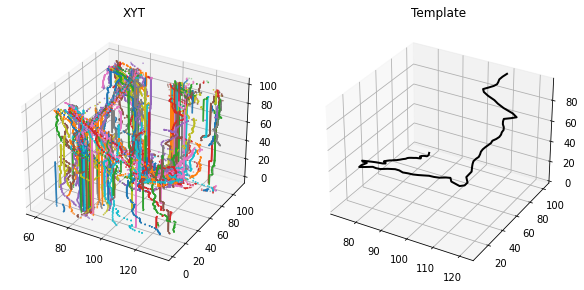

In [ ]:
template = templates_smoothed[templates_smoothed['trajectory_type'] == 4][['X', 'Y', 'lindist_binned']].values
X1 = X_collected2[4]
Y1 = Y_collected2[4]
L1 = L_collected2[4]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')

for i in range(len(X1)):

    x_path = X1[i]
    y_path = Y1[i]
    z_path = L1[i]  # use T_collected as z

    assert len(x_path) == len(y_path) == len(z_path)

    ax1.scatter(x_path, y_path, z_path, s=0.5)

ax1.set_title('XYT')

ax2 = fig.add_subplot(122, projection='3d')

x_template = template[:, 0]
y_template = template[:, 1]
z_template = template[:, 2]  # use template time as z

assert len(x_template) == len(y_template) == len(z_template)

ax2.plot(x_template, y_template, z_template, color='k', linewidth=2)  # 使用红色线条并增加线宽

ax2.set_title('Template')

plt.show()
